In [1]:
import math
import os

import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

import lpips
from model import Generator
import numpy as np
from util import *

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def gaussian_loss(v):
    # [B, 9088]
    loss = (v-gt_mean) @ gt_cov_inv @ (v-gt_mean).transpose(1,0)
    return loss.mean()

def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(0, 2, 3, 1)
        .to('cpu')
        .numpy()
    )

In [3]:
resize = 256

transform = transforms.Compose(
    [
        transforms.Resize(resize),
        transforms.CenterCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

In [4]:
device = 'cuda'

imgfile = 'imgs/01.jpg'
imgs = []

img = transform(Image.open(imgfile).convert('RGB'))
imgs.append(img)

imgs = torch.stack(imgs, 0).to(device)

imgs.shape

torch.Size([1, 3, 256, 256])

In [5]:
g_ema = Generator(resize, 512, 8)
ensure_checkpoint_exists('face.pt')
g_ema.load_state_dict(torch.load('face.pt')['g_ema'], strict=False)
g_ema = g_ema.to(device).eval()

In [6]:
with torch.no_grad():
    latent_mean = g_ema.mean_latent(50000)
    latent_in = list2style(latent_mean)

# get gaussian stats
if not os.path.isfile('inversion_stats.npz'):
    with torch.no_grad():
        source = list2style(g_ema.get_latent(torch.randn([10000, 512]).cuda())).cpu().numpy()
        gt_mean = source.mean(0)
        gt_cov = np.cov(source, rowvar=False)

    # We show that style space follows gaussian distribution
    # An extension from this work https://arxiv.org/abs/2009.06529
    np.savez('inversion_stats.npz', mean=gt_mean, cov=gt_cov)

data = np.load('inversion_stats.npz')
gt_mean = torch.tensor(data['mean']).cuda().view(1,-1).float()
gt_cov_inv = torch.tensor(data['cov']).cuda()

# Only take diagonals
mask = torch.eye(*gt_cov_inv.size()).cuda()
gt_cov_inv = torch.inverse(gt_cov_inv*mask).float()

In [7]:
step = 3000
lr = 1.0

percept = lpips.LPIPS(net='vgg', spatial=True).to(device)
latent_in.requires_grad = True

optimizer = optim.Adam([latent_in], lr=lr, betas=(0.9, 0.999))

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: C:\Users\Brad\anaconda3\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [8]:
min_latent = None
min_loss = 100
pbar = tqdm(range(step))
latent_path = []

for i in pbar:
    t = i / step
#     lr = get_lr(t, lr)
    if i > 0 and i % 500 == 0:
        lr *= 0.2
    latent_n = latent_in

    img_gen, _ = g_ema(style2list(latent_n))

    batch, channel, height, width = img_gen.shape

    if height > 256:
        img_gen = F.interpolate(img_gen, size=(256,256), mode='area')

    p_loss = 20*percept(img_gen, imgs).mean()
    mse_loss = 1*F.mse_loss(img_gen, imgs)
    g_loss = 1e-3*gaussian_loss(latent_n)

    loss = p_loss + mse_loss + g_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % 100 == 0:
        latent_path.append(latent_in.detach().clone())
        
    if loss.item() < min_loss:
        min_loss = loss.item()
        min_latent = latent_in.detach().clone()

    pbar.set_description(
        (
            f'loss: {loss.item():.4f}; '
            f'perceptual: {p_loss.item():.4f}; '
            f'mse: {mse_loss.item():.4f}; gaussian: {g_loss.item():.4f} lr: {lr:.4f}'
        )
    )
    
latent_path.append(latent_in.detach().clone()) # last latent vector

print(min_loss)

loss: 5.3661; perceptual: 4.0913; mse: 0.0134; gaussian: 1.2615 lr: 0.0003: 100%|██| 3000/3000 [02:34<00:00, 19.45it/s]

4.651237964630127


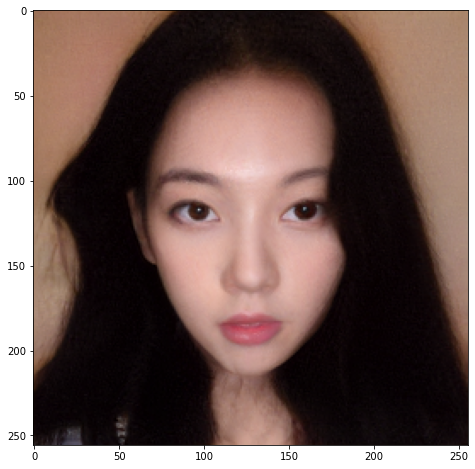

In [9]:
img_gen, _ = g_ema(style2list(latent_path[-1]))

plt.figure(figsize=(8, 8))
plt.imshow(make_image(img_gen)[0])

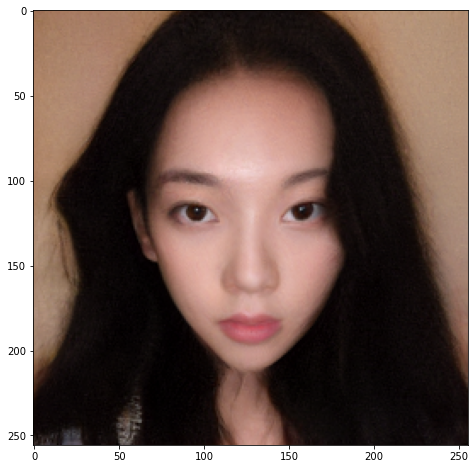

In [10]:
img_gen, _ = g_ema(style2list(min_latent))

plt.figure(figsize=(8, 8))
plt.imshow(make_image(img_gen)[0])

In [11]:
torch.save({'latent': min_latent}, 'inversion_codes/01.pt')